<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12a_MatMulExplainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Multiplication explainer
A tool for explaining the output value from matrix multiplication, particularly for near-zero outputs.

In [39]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout ea80c40
!cd repo && git pull

import sys
sys.path.append('repo')

import matmul_explainer as me
from importlib import reload
reload(me)

HEAD is now at 8a7946f WIP developing filter_classifications()
Already up to date.


<module 'matmul_explainer' from '/content/repo/matmul_explainer.py'>

In [40]:
import matmul_explainer_test
reload(matmul_explainer_test)
matmul_explainer_test.run_test_suite()

All matmul_explainer tests passed.


In [41]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math

## Classification
First we need to be able to classify the components that make up the matrix multiplication results.

We do that with a number of functions:

```
def classify_terms():
  return ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']

def matmul_classify(x1, x2, confidence: float=0.95, threshold1: float = None, threshold2: float = None):
 ...
 return counts, sums
```


In [ ]:
# Standard ordered terms
print(f"Terms: {me.classify_terms()}")

Terms: ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']


In [ ]:
# Check that the summarisation API works under a number of usages:
reload(me)
a = np.arange(0.0, 1.0, 0.1)
a = np.tile(a, (10,1))
counts, sums = me.matmul_classify(a, a, confidence=0.75)

print(f"Summary when passed counts and sums separately:\n  {me.summarise(counts, sums)}")
print(f"Summary when passed counts and sums directly from classification:\n  {me.summarise(me.matmul_classify(a, a, confidence=0.75))}")


Summary when passed counts and sums separately:
  PP: 640 = 193.6, ZP: 160 = 4.399999999999999, PZ: 160 = 4.4, ZZ: 40 = 0.10000000000000003
Summary when passed counts and sums directly from classification:
  PP: 640 = 193.6, ZP: 160 = 4.399999999999999, PZ: 160 = 4.4, ZZ: 40 = 0.10000000000000003


In [ ]:
# Show how the values within tensors get classified
def show_classification_results(x, confidence):
  p, z, n, t = me.classification_mask(x, confidence=confidence)
  print(f"classification results for {x} @ {confidence}:")
  print(f"  threshold: {t}")
  print(f"  p: {p}")
  print(f"  z: {z}")
  print(f"  n: {n}")

a = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
show_classification_results(a, confidence=0.75)

a = np.array([-0.5, 0, -0.5])
show_classification_results(a, confidence=0.75)

a = np.array([-0.5, 0.25, 0, 0.25, -0.5])
show_classification_results(a, confidence=0.95)

classification results for [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] @ 0.75:
  threshold: 0.25
  p: [False False False  True  True  True  True  True  True  True]
  z: [ True  True  True False False False False False False False]
  n: [False False False False False False False False False False]
classification results for [-0.5  0.  -0.5] @ 0.75:
  threshold: 0.25
  p: [False False False]
  z: [False  True False]
  n: [ True False  True]
classification results for [-0.5   0.25  0.    0.25 -0.5 ] @ 0.95:
  threshold: 0.125
  p: [False  True False  True False]
  z: [False False  True False False]
  n: [ True False False False  True]


In [ ]:
# Simple 2D matmul explanation
reload(me)
a = np.arange(0.0, 1.0, 0.1)
a = np.tile(a, (10,1))
print(f"a = b = {a}")

counts, sums = me.matmul_classify(a, a, confidence=0.75)

print()
print("Details...")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[:,:,i]) > 0:
    print(f"Counts({name}): {counts[:,:,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[:,:,i]) > 0:
    print(f"Sums({name}): {sums[:,:,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
print(f"True matmul: {np.matmul(a, a)}")
print(f"Derived matmul: {np.sum(sums, axis=-1)}")


a = b = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]]

Details...
Counts(PP): [[0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]
 [0 0 8 8 8 8 8 8 8 8]]
Counts(PZ): [[8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]
 [8 8 0 0 0 0 0 0 0 0]]
Counts(ZP): [[0 0 2 2 2 2 2 2 2 2]
 [0 0 2 2 2 2 2 2 2 2]
 [0 0

In [ ]:
# 2D convolution explanation
a = np.arange(0.0, 0.9, 0.1)
a = np.tile(a, (9,1)).astype(np.float32)
a = tf.reshape(a, shape=(1,9,9,1))
print(f"a = b: {a.shape} = {a[0,:,:,0]}")

k = np.array([
    [-1, 0, -1],
    [+1, +1, +1],
    [-1, 0, -1]
]).astype(np.float32)
k = tf.reshape(k, shape=(3,3,1,1))
print(f"k = {k.shape} = {k[:,:,0,0]}")

counts, sums = me.conv_classify(a, k, confidence=0.75)
print()
print("Results...")
print(f"Shapes: counts={counts.shape}, sums={sums.shape}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Counts({name}): {counts[0,:,:,0,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Sums({name}): {sums[0,:,:,0,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2,3))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2,3))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
expected_conv = tf.nn.convolution(a, k)
derived_conv = tf.reduce_sum(sums, axis=-1)
print(f"True conv: {expected_conv.shape} = {expected_conv[0,:,:,0]}")
print(f"Derived conv: {derived_conv.shape} = {derived_conv[0,:,:,0]}")
print(f"Devired conv == true conv: {np.allclose(expected_conv, derived_conv)}")


a = b: (1, 9, 9, 1) = [[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]]
k = (3, 3, 1, 1) = [[-1.  0. -1.]
 [ 1.  1.  1.]
 [-1.  0. -1.]]

Results...
Shapes: counts=(1, 7, 7, 1, 9), sums=(1, 7, 7, 1, 9)
Counts(PP): [[1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]
 [1. 2. 3. 3. 3. 3. 3.]]
Counts(PZ): [[0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2. 2. 2.]]
Counts(PN): [[2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [2. 2. 4. 4. 4. 4. 4.]
 [

In [ ]:
# 1D convolution explanation
reload(me)
a = np.arange(0.0, 0.9, 0.1).astype(np.float32)
a = tf.reshape(a, shape=(1,9,1))
print(f"a = b: {a.shape} = {a[0,:,0]}")

k = np.array([-1, 0, -1]).astype(np.float32)
k = tf.reshape(k, shape=(3,1,1))
print(f"k = {k.shape} = {k[:,0,0]}")

counts, sums, thresholds = me.conv_classify(a, k, confidence=0.90, return_thresholds=True)
print()
print("Results...")
print(f"Shapes: counts={counts.shape}, sums={sums.shape}, thresholds={thresholds}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Counts({name}): {counts[0,:,0,i]}")
for i, name in enumerate(me.classify_terms()):
  if np.sum(counts[...,i]) > 0:
    print(f"Sums({name}): {sums[0,:,0,i]}")

print()
print("Summary...")
print(f"Classes: {me.classify_terms()}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2))}")
print(f"Summary: {me.summarise(counts, sums)}")

print()
print("Validation...")
expected_conv = tf.nn.convolution(a, k)
derived_conv = tf.reduce_sum(sums, axis=-1)
print(f"True conv: {expected_conv.shape} = {expected_conv[0,:,0]}")
print(f"Derived conv: {derived_conv.shape} = {derived_conv[0,:,0]}")
print(f"Devired conv == true conv: {np.allclose(expected_conv, derived_conv)}")

a = b: (1, 9, 1) = [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
k = (3, 1, 1) = [-1.  0. -1.]

Results...
Shapes: counts=(1, 7, 1, 9), sums=(1, 7, 1, 9), thresholds=[0.05, 0.5]
Counts(PZ): [1. 1. 1. 1. 1. 1. 1.]
Counts(PN): [1. 2. 2. 2. 2. 2. 2.]
Counts(ZN): [1. 0. 0. 0. 0. 0. 0.]
Sums(PZ): [0. 0. 0. 0. 0. 0. 0.]
Sums(PN): [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Sums(ZN): [0. 0. 0. 0. 0. 0. 0.]

Summary...
Classes: ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']
Counts by class: [ 0.  7. 13.  0.  0.  1.  0.  0.  0.]
Sums by class: [ 0.   0.  -5.6  0.   0.   0.   0.   0.   0. ]
Summary: PN: 13.0 = -5.599999904632568, PZ: 7.0 = 0.0, ZN: 1.0 = 0.0

Validation...
True conv: (1, 7, 1) = [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Derived conv: (1, 7, 1) = [-0.2       -0.4       -0.6       -0.8       -1.        -1.2
 -1.4000001]
Devired conv == true conv: True


In [ ]:
# Simple single tensor explanation
a = np.arange(0.0, 0.9, 0.1).astype(np.float32)
a = tf.reshape(a, shape=(1,9,1))

counts, sums, thresholds = me.tensor_classify(a, confidence=0.90, return_threshold=True)
print(f"Shapes: counts={counts.shape}, sums={sums.shape}, thresholds={thresholds}")
print(f"Classes: {me.classify_terms(counts)}")
print(f"Counts by class: {np.sum(counts, axis=(0,1,2))}")
print(f"Sums by class: {np.sum(sums, axis=(0,1,2))}")
print(f"Summary: {me.summarise(counts, sums)}")



Shapes: counts=(1, 9, 1, 3), sums=(1, 9, 1, 3), thresholds=0.05000000074505806
Classes: ['P', 'Z', 'N']
Counts by class: [8. 1. 0.]
Sums by class: [3.6 0.  0. ]
Summary: P: 8.0 = 3.5999999046325684, Z: 1.0 = 0.0


## Detailed Summary
Now for a more detailed summarisation that works with masking to identify the range of causes for problems with specific output tensor positions.

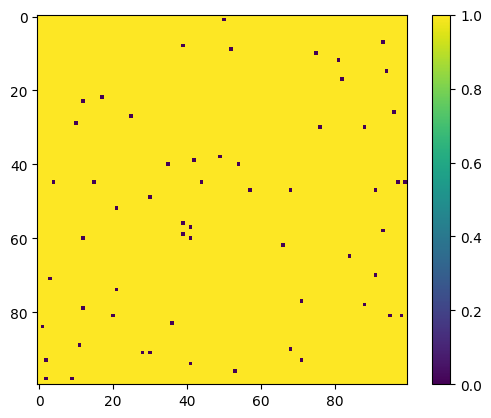

In [43]:
a = np.random.uniform(-5, +5, (100,100)).astype(int).astype(float)
b = np.random.uniform(-5, +5, (100,100)).astype(int).astype(float)
res = np.matmul(a, b)
plt.imshow(res != 0)
plt.colorbar()

In [ ]:
print(f"Basic summary: {me.summarise(me.matmul_classify(a,b))}")

Basic summary: NP: 161134 = -988454.0, PP: 159795 = 986502.0, NN: 159729 = 986466.0, PN: 157828 = -978566.0, ZP: 80971 = 0.0, ZN: 80543 = 0.0, PZ: 79677 = 0.0, NZ: 79437 = 0.0, ZZ: 40886 = 0.0


counts: (100, 100, 9)
counts: (100, 100, 9)


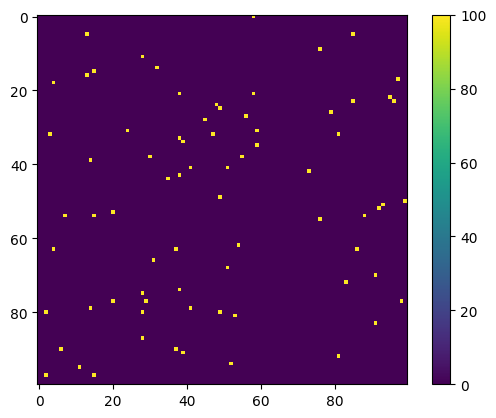

In [ ]:
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)
#print(f"Basic summary: {me.summarise(counts, sums)}")
print(f"counts: {counts.shape}")
counts = counts * mask[..., np.newaxis]
print(f"counts: {counts.shape}")
plt.imshow(np.sum(counts, axis=-1))
plt.colorbar()


In [ ]:
counts, sums = me.matmul_classify(a,b)
print(f"counts: {counts.shape}")

counts: (100, 100, 9)


sorted counts: (100, 100, 9)
sorted counts: (100, 100, 9)


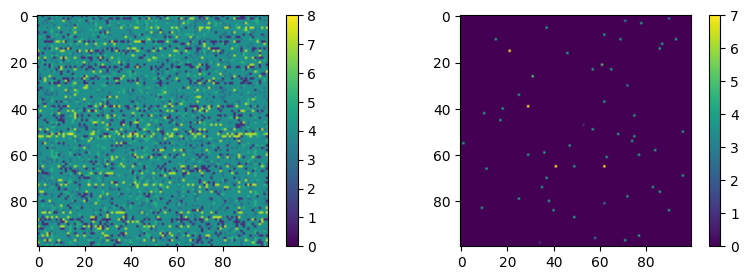

In [ ]:
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
argsrt = np.argsort(counts, axis=-1)
print(f"sorted counts: {argsrt.shape}")
plt.imshow(argsrt[:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
mask = res == 0
counts = counts * mask[..., np.newaxis]
argsrt = np.argsort(counts, axis=-1)
print(f"sorted counts: {argsrt.shape}")
plt.imshow(argsrt[:,:,0])
plt.colorbar()

plt.show()

In [ ]:
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)

for i, indices in enumerate(zip(*np.where(mask))):
  if i > 10:
    break
  print(f"index: {indices} - counts: {counts[indices]} - sums: {sums[indices]}")
  pos_range = sums[indices][sums[indices] > 0]
  print(f"pos_range: {pos_range}")

index: (1, 90) - counts: [12  8 11  5  6 13 22  6 17] - sums: [  96.    0.  -49.    0.    0.    0. -146.    0.   99.]
pos_range: [96. 99.]
index: (2, 71) - counts: [15 11 14  2  6  6 21  3 22] - sums: [ 105.    0.  -90.    0.    0.    0. -152.    0.  137.]
pos_range: [105. 137.]
index: (3, 78) - counts: [22  8 16  5  2 10 17  8 12] - sums: [ 133.    0. -114.    0.    0.    0.  -76.    0.   57.]
pos_range: [133.  57.]
index: (5, 37) - counts: [18  8 20 13  4  5 14  7 11] - sums: [119.   0. -98.   0.   0.   0. -90.   0.  69.]
pos_range: [119.  69.]
index: (8, 62) - counts: [17  6 16  9  2  5 16 10 19] - sums: [ 110.    0. -121.    0.    0.    0. -117.    0.  128.]
pos_range: [110. 128.]
index: (10, 15) - counts: [14 11 20 10  3  4 18  9 11] - sums: [ 107.    0.  -85.    0.    0.    0. -123.    0.  101.]
pos_range: [107. 101.]
index: (10, 69) - counts: [16  6 23  5  4  8 16  9 13] - sums: [  83.    0.  -93.    0.    0.    0. -100.    0.  110.]
pos_range: [ 83. 110.]
index: (10, 93) - coun

In [74]:
def _classify_terms(example=None, retain_shape=True):
    """
    Identifies the appropriate terms list based on the example given, or otherwise
    assumes the terms for a full mat-mul like operation.

    Args:
        example: a count or sum result from a call to matmul_classify() or similar,
            or the tensor containing both the count and sum.
        retain_shape: whether to tile the terms out and to return an array
            in the same shape as the provided example. Only allowed if an example is included.

    Returns:
        list of strings, containing the names of the terms in the default order
        OR
        np-array in same shape as example with identified term for each value
    """
    shape = None
    if example is None:
        tensor_count = 2   # default
    else:
        if isinstance(example, tuple):
            example, _ = example
        shape = np.shape(example)
        channels = shape[-1]
        if channels == 3:
            tensor_count = 1
        elif channels == 9:
            tensor_count = 2
        else:
            raise ValueError("Unrecognised example with {channels} in last dim: {shape}")

    if tensor_count == 1:
        term_list = ['P', 'Z', 'N']
    else:
        term_list = ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN']

    if retain_shape:
        if shape is None:
            raise ValueError("Cannot retain shape without example")
        value_shape = shape[:-1]
        term_count = len(term_list)
        term_array = np.array(term_list)
        terms = np.reshape(term_array, (1,) * len(value_shape) + (term_count,))
        terms = np.tile(terms, reps=value_shape + (1,))
        return terms
    else:
        return term_list

print(f"scalar x 9 terms:")
counts = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8]])
terms = _classify_terms(counts, retain_shape=True)
print(f"shapes: counts={counts.shape}, terms={terms.shape}")
print(f"terms: {terms}")

print(f"2d x 9 terms:")
counts = np.array([
    [[0, 1, 2, 3, 4, 5, 6, 7, 8], [8, 7, 6, 5, 4, 3, 2, 1, 0]]
])
terms = _classify_terms(counts, retain_shape=True)
print(f"shapes: counts={counts.shape}, terms={terms.shape}")
print(f"terms: {terms}")

print(f"2d x 3 terms:")
counts = np.array([
    [[0, 1, 2], [8, 7, 6]]
])
terms = _classify_terms(counts, retain_shape=True)
print(f"shapes: counts={counts.shape}, terms={terms.shape}")
print(f"terms: {terms}")

scalar x 9 terms:
shapes: counts=(1, 9), terms=(1, 9)
terms: [['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' 'NN']]
2d x 9 terms:
shapes: counts=(1, 2, 9), terms=(1, 2, 9)
terms: [[['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' 'NN']
  ['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' 'NN']]]
2d x 3 terms:
shapes: counts=(1, 2, 3), terms=(1, 2, 3)
terms: [[['P' 'Z' 'N']
  ['P' 'Z' 'N']]]


In [102]:
def _partial_filter_by_sum(counts, sums, terms, masks, completeness):
  # determine thresholds against sums
  pos_range = np.sum((sums * (sums > 0)), axis=-1)
  neg_range = np.abs(np.sum((sums * (sums < 0)), axis=-1))
  abs_range = np.maximum(pos_range, neg_range)
  threshold = abs_range * (1 - completeness)  # shape: value_shape

  # sort everything according to sum magnitudes, smallest first for cumsum
  sort_order = np.argsort(np.abs(sums), axis=-1)
  counts = np.take_along_axis(counts, sort_order, axis=-1)
  sums = np.take_along_axis(sums, sort_order, axis=-1)
  terms = np.take_along_axis(terms, sort_order, axis=-1)
  masks = np.take_along_axis(masks, sort_order, axis=-1)  # shape: value_shape + (terms,)

  # update masks
  # - starting from front, sums up positive and negative "marginal" sums separately
  # - the threshold point is the point where the max of the absolute margins >= threshold
  pos_margin_sums = np.cumsum(sums * (sums > 0), axis=-1)
  neg_margin_sums = np.cumsum(sums * (sums < 0), axis=-1)
  mag_margin_sums = np.maximum(pos_margin_sums, np.abs(neg_margin_sums))  # shape: value_shape + (terms,)
  threshold_mask = mag_margin_sums >= threshold[..., np.newaxis]  # shape: value_shape + (terms,)
  masks = np.logical_or(threshold_mask, masks)

  # flip final results for largest-to-smallest order
  counts = np.flip(counts, axis=-1)
  sums = np.flip(sums, axis=-1)
  terms = np.flip(terms, axis=-1)
  masks = np.flip(masks, axis=-1)
  return counts, sums, terms, masks

def _partial_filter_by_sum_test():
  counts = np.array([
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
  ])
  sums = np.array([
      [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
      [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
      [8, 15, 21, 26, 30, 33, 35, 36, 0],
  ])
  expected_counts = np.array([
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
      [1, 3, 5, 7, 8, 6, 4, 2, 0],
      [1, 2, 3, 4, 5, 6, 7, 8, 0],
  ])
  expected_sums = np.array([
      [36, 28, 21, 15, 10, 6, 3, 1, 0],
      [36, 28, 21, 15, 10, 6, 3, 1, 0],
      [36, 35, 33, 30, 26, 21, 15, 8, 0],
  ])
  expected_terms = np.array([
      ['NN', 'NZ', 'NP', 'ZN', 'ZZ', 'ZP', 'PN', 'PZ', 'PP'],
      ['PZ', 'ZP', 'ZN', 'NZ', 'NN', 'NP', 'ZZ', 'PN', 'PP'],
      ['NZ', 'NP', 'ZN', 'ZZ', 'ZP', 'PN', 'PZ', 'PP', 'NN'],
  ])
  expected_masks = np.array([
      [True, True, True, True, False, False, False, False, False],
      [True, True, True, True, False, False, False, False, False],
      [True, True, True, True, True, False, False, False, False],
  ])

  terms = _classify_terms(counts, retain_shape=True)
  masks = np.zeros_like(counts, dtype=bool)
  counts, sums, terms, masks = _partial_filter_by_sum(counts, sums, terms, masks, completeness=0.75)
  assert np.all(counts == expected_counts), f"Expected counts {expected_counts}, got: {counts}"
  assert np.all(sums == expected_sums), f"Expected sums {expected_sums}, got: {sums}"
  assert np.all(terms == expected_terms), f"Expected terms {expected_terms}, got: {terms}"
  assert np.all(masks == expected_masks), f"Expected masks {expected_masks}, got: {masks}"

_partial_filter_by_sum_test()

counts = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [8, 7, 6, 5, 4, 3, 2, 1, 0],
])
sums = np.array([
    [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
    [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
    [8, 15, 21, 26, 30, 33, 35, 36, 0],
])
terms = _classify_terms(counts, retain_shape=True)
masks = np.zeros_like(counts, dtype=bool)
counts, sums, terms, masks = _partial_filter_by_sum(counts, sums, terms, masks, completeness=0.75)
print(f"counts: {counts}")
print(f"sums: {sums}")
print(f"terms: {terms}")
print(f"masks: {masks}")



counts: [[8 7 6 5 4 3 2 1 0]
 [1 3 5 7 8 6 4 2 0]
 [1 2 3 4 5 6 7 8 0]]
sums: [[36 28 21 15 10  6  3  1  0]
 [36 28 21 15 10  6  3  1  0]
 [36 35 33 30 26 21 15  8  0]]
terms: [['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PN' 'PZ' 'PP']
 ['PZ' 'ZP' 'ZN' 'NZ' 'NN' 'NP' 'ZZ' 'PN' 'PP']
 ['NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PN' 'PZ' 'PP' 'NN']]
masks: [[ True  True  True  True False False False False False]
 [ True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False]]


In [103]:
def _partial_filter_by_count(counts, sums, terms, masks, completeness):
  # determine thresholds against counts
  threshold = np.sum(counts, axis=-1) * (1 - completeness)
  print(f"threshold (counts): {threshold.shape} in range {np.min(threshold)} .. {np.max(threshold)}")

  # sort everything according to counts, smallest first for cumsum
  sort_order = np.argsort(counts, axis=-1)
  counts = np.take_along_axis(counts, sort_order, axis=-1)
  sums = np.take_along_axis(sums, sort_order, axis=-1)
  terms = np.take_along_axis(terms, sort_order, axis=-1)
  masks = np.take_along_axis(masks, sort_order, axis=-1)  # shape: value_shape + (terms,)

  # update masks
  # - starting from front, sums up "marginal" counts
  # - the threshold point is the point where the margins >= threshold
  margin_counts = np.cumsum(counts, axis=-1)  # shape: value_shape + (terms,)
  threshold_mask = margin_counts >= threshold[..., np.newaxis]  # shape: value_shape + (terms,)
  masks = np.logical_or(threshold_mask, masks)

  # flip final results for largest-to-smallest order
  counts = np.flip(counts, axis=-1)
  sums = np.flip(sums, axis=-1)
  terms = np.flip(terms, axis=-1)
  masks = np.flip(masks, axis=-1)
  return counts, sums, terms, masks

def _partial_filter_by_count_test():
  counts = np.array([
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
  ])
  sums = np.array([
      [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
      [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
      [8, 15, 21, 26, 30, 33, 35, 36, 0],
  ])
  expected_counts = np.array([
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
  ])
  expected_sums = np.array([
      [36, 28, 21, 15, 10, 6, 3, 1, 0],
      [10, 15, 6, 21, 3, 28, 1, 36, 0],
      [8, 15, 21, 26, 30, 33, 35, 36, 0],
  ])
  expected_terms = np.array([
      ['NN', 'NZ', 'NP', 'ZN', 'ZZ', 'ZP', 'PN', 'PZ', 'PP'],
      ['NN', 'NZ', 'NP', 'ZN', 'ZZ', 'ZP', 'PN', 'PZ', 'PP'],
      ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', 'NN'],
  ])
  expected_masks = np.array([
      [True, True, True, True, True, False, False, False, False],
      [True, True, True, True, True, False, False, False, False],
      [True, True, True, True, True, False, False, False, False],
  ])

  terms = _classify_terms(counts, retain_shape=True)
  masks = np.zeros_like(counts, dtype=bool)
  counts, sums, terms, masks = _partial_filter_by_count(counts, sums, terms, masks, completeness=0.75)
  assert np.all(counts == expected_counts), f"Expected counts {expected_counts}, got: {counts}"
  assert np.all(sums == expected_sums), f"Expected sums {expected_sums}, got: {sums}"
  assert np.all(terms == expected_terms), f"Expected terms {expected_terms}, got: {terms}"
  assert np.all(masks == expected_masks), f"Expected masks {expected_masks}, got: {masks}"

_partial_filter_by_count_test()

counts = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [8, 7, 6, 5, 4, 3, 2, 1, 0],
])
sums = np.array([
    [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
    [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
    [8, 15, 21, 26, 30, 33, 35, 36, 0],
])
terms = _classify_terms(counts, retain_shape=True)
masks = np.zeros_like(counts, dtype=bool)
counts, sums, terms, masks = _partial_filter_by_count(counts, sums, terms, masks, completeness=0.75)
print(f"counts: {counts}")
print(f"sums: {sums}")
print(f"terms: {terms}")
print(f"masks: {masks}")


threshold (counts): (3,) in range 9.0 .. 9.0
threshold (counts): (3,) in range 9.0 .. 9.0
counts: [[8 7 6 5 4 3 2 1 0]
 [8 7 6 5 4 3 2 1 0]
 [8 7 6 5 4 3 2 1 0]]
sums: [[36 28 21 15 10  6  3  1  0]
 [10 15  6 21  3 28  1 36  0]
 [ 8 15 21 26 30 33 35 36  0]]
terms: [['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PN' 'PZ' 'PP']
 ['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PN' 'PZ' 'PP']
 ['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' 'NN']]
masks: [[ True  True  True  True  True False False False False]
 [ True  True  True  True  True False False False False]
 [ True  True  True  True  True False False False False]]


In [105]:
def filter_classifications(counts, sums, completeness=0.75):
  """
  Filters classification data in order to retain a certain
  "completeness of explanatory coverage". This eliminates less important noise,
  making it easier to understand any summaries produced from it.
  It is also useful for grouping similar classification results that have
  the same major structure, while ignoring less important noise.

  The final returned counts, sums, and terms are sorted for descending
  counts.

  Everything is determined independently for each each position
  within the original value tensor, including for final sort. Thus the result
  also includes a terms tensor, with the same shape as counts and sums,
  in order to identify the final terms order for each position.

  Returns:
    (counts, sums, terms) - sorted and filtered
  """
  # steps:
  # - initialise a full tuple of (counts, sums, terms, masks) that will always be sorted
  #   together simultaneously
  # - do a sort and filter by sums first
  #   - while the final output is primarily by count, sometimes there are a small number
  #     of unusually large values and we want to see those too
  # - then do a sort and filter by counts
  # - combine final result masks
  # - set all rejected values to zeros
  # - final result is sorted according to counts, largest first
  terms = _classify_terms(counts, retain_shape=True)
  masks = np.zeros_like(counts, dtype=bool)
  counts, sums, terms, masks = _partial_filter_by_sum(counts, sums, terms, masks, completeness)
  counts, sums, terms, masks = _partial_filter_by_count(counts, sums, terms, masks, completeness)

  # apply masks
  counts = counts * masks
  sums = sums * masks
  terms = np.where(masks, terms, '--')

  # apply final sorting - by descending count after masking
  # - although _partial_filter_by_count() will have returned things in the right sort order,
  #   now that we've applied the mask, some of the counts have changed to zero and the order
  #   isn't now quite accurate.
  # - for example, if there's a low-count high-sum, it'll be at the end somewhere
  #   and now needs to come further forward.
  sort_order = np.argsort(-counts, axis=-1)  # negate for descending order
  counts = np.take_along_axis(counts, sort_order, axis=-1)
  sums = np.take_along_axis(sums, sort_order, axis=-1)
  terms = np.take_along_axis(terms, sort_order, axis=-1)
  return counts, sums, terms

def filter_classifications_test():
  counts = np.array([
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [0, 1, 2, 3, 4, 5, 6, 7, 8],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
  ])
  sums = np.array([
      [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
      [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
      [8, 15, 21, 26, 30, 33, 35, 36, 0],
  ])
  expected_counts = np.array([
      [8, 7, 6, 5, 4, 0, 0, 0, 0],
      [8, 7, 6, 5, 4, 3, 1, 0, 0],
      [8, 7, 6, 5, 4, 3, 2, 1, 0],
  ])
  expected_sums = np.array([
      [36, 28, 21, 15, 10, 0, 0, 0, 0],
      [10, 15, 6, 21, 3, 28, 36, 0, 0],
      [8, 15, 21, 26, 30, 33, 35, 36, 0],
  ])
  expected_terms = np.array([
      ['NN', 'NZ', 'NP', 'ZN', 'ZZ', '--', '--', '--', '--'],
      ['NN', 'NZ', 'NP', 'ZN', 'ZZ', 'ZP', 'PZ', '--', '--'],
      ['PP', 'PZ', 'PN', 'ZP', 'ZZ', 'ZN', 'NP', 'NZ', '--'],
  ])

  counts, sums, terms = filter_classifications(counts, sums, completeness=0.75)
  assert np.all(counts == expected_counts), f"Expected counts {expected_counts}, got: {counts}"
  assert np.all(sums == expected_sums), f"Expected sums {expected_sums}, got: {sums}"
  assert np.all(terms == expected_terms), f"Expected terms {expected_terms}, got: {terms}"

filter_classifications_test()

counts = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [8, 7, 6, 5, 4, 3, 2, 1, 0],
])
sums = np.array([
    [ 0,  1,  3,  6, 10, 15, 21, 28, 36],
    [ 0, 36, 1, 28, 3, 21, 6, 15, 10],
    [8, 15, 21, 26, 30, 33, 35, 36, 0],
])
counts, sums, terms = filter_classifications(counts, sums, completeness=0.75)
print(f"counts: {counts}")
print(f"sums: {sums}")
print(f"terms: {terms}")

threshold (counts): (3,) in range 9.0 .. 9.0
threshold (counts): (3,) in range 9.0 .. 9.0
counts: [[8 7 6 5 4 0 0 0 0]
 [8 7 6 5 4 3 1 0 0]
 [8 7 6 5 4 3 2 1 0]]
sums: [[36 28 21 15 10  0  0  0  0]
 [10 15  6 21  3 28 36  0  0]
 [ 8 15 21 26 30 33 35 36  0]]
terms: [['NN' 'NZ' 'NP' 'ZN' 'ZZ' '--' '--' '--' '--']
 ['NN' 'NZ' 'NP' 'ZN' 'ZZ' 'ZP' 'PZ' '--' '--']
 ['PP' 'PZ' 'PN' 'ZP' 'ZZ' 'ZN' 'NP' 'NZ' '--']]


In [ ]:
res = np.matmul(a, b)
mask = res == 0
counts, sums = me.matmul_classify(a,b)

filtered_counts, filtered_sums, filtered_terms = filter_classifications(counts, sums)

for i, indices in enumerate(zip(*np.where(mask))):
  if i > 10:
    break

  print(f"index: {indices} - counts: {counts[indices]} - sums: {sums[indices]}")
  print(f"filtered_counts: {filtered_counts[indices]} - filtered_sums: {filtered_sums[indices]} - filtered_terms: {filtered_terms[indices]}")

threshold: (100, 100) in range 33.0 .. 96.75
index: (1, 90) - counts: [12  8 11  5  6 13 22  6 17] - sums: [  96.    0.  -49.    0.    0.    0. -146.    0.   99.]
filtered_counts: [22 17 12 11  0  0  0  0  0] - filtered_sums: [-146.   99.   96.  -49.    0.    0.    0.    0.    0.] - filtered_terms: ['NP' 'NN' 'PP' 'PN' '--' '--' '--' '--' '--']
index: (2, 71) - counts: [15 11 14  2  6  6 21  3 22] - sums: [ 105.    0.  -90.    0.    0.    0. -152.    0.  137.]
filtered_counts: [21 22 15 14  0  0  0  0  0] - filtered_sums: [-152.  137.  105.  -90.    0.    0.    0.    0.    0.] - filtered_terms: ['NP' 'NN' 'PP' 'PN' '--' '--' '--' '--' '--']
index: (3, 78) - counts: [22  8 16  5  2 10 17  8 12] - sums: [ 133.    0. -114.    0.    0.    0.  -76.    0.   57.]
filtered_counts: [22 16 17 12  0  0  0  0  0] - filtered_sums: [ 133. -114.  -76.   57.    0.    0.    0.    0.    0.] - filtered_terms: ['PP' 'PN' 'NP' 'NN' '--' '--' '--' '--' '--']
index: (5, 37) - counts: [18  8 20 13  4  5 14  7

In [ ]:
del range

In [ ]:
67mask = sums > 0

sums[mask].shape

(20000,)

In [ ]:
np.nonzero(mask)

3

In [ ]:
mask = sums[..., 1] > 0
#sums[np.nonzero(mask) + (1,)]
indices = np.nonzero(mask)
indices + (1,)

(array([], dtype=int64), array([], dtype=int64), 1)

In [ ]:
terms = np.array(me.classify_terms())
#sh =
terms = np.reshape(t, (1,) * (len(counts.shape) - 1) + (counts.shape[-1],))
np.tile(terms, reps=counts.shape[:-1] + (1,)).shape

(100, 100, 9)

In [ ]:
counts.shape[:-1]

(100, 100)

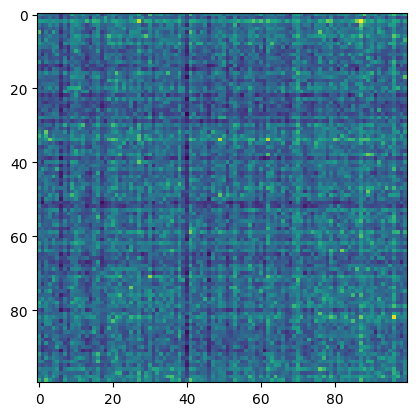

In [ ]:
pos_range = np.sum((sums * (sums > 0)), axis=-1)
neg_range = np.abs(np.sum((sums * (sums < 0)), axis=-1))
range = np.maximum(pos_range, neg_range)
range
plt.imshow(range)